# Question 1

# Problem Setup

You are provided with a system of 3 qubits, giving you an unstructured quantum search space of:

N=23=8 possible states(|000⟩,|001⟩,...,|111⟩) 

One of these states — in this case, the state |101⟩ — represents a "collision", i.e., the correct answer or the marked solution. Your task is to use Grover's algorithm to identify this collision state efficiently.

In [269]:
n = 3  # Number of qubits
N = 2 ** n
solution = '101'  # Marked element (the "needle")

**Task** : Apply Hadamard gates to all qubits to prepare a uniform superposition over all 8 states.

In [271]:
qc = QuantumCircuit(n, n)
qc.h(range(n))

**Task** : Build a quantum oracle that recognizes the collision state |101⟩ and flips its phase.

**Explanation** : This function checks the 'solution' bitwise and implements gates on the superposition created above accordingly. Using this, we only flip the phase of the solution qubit.

In [276]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

**Task** : Implement the diffusion step that inverts amplitudes about their average

**Explanation** : This function effectively implements the gate D = I - 2|0><0|, which flips all the amplitudes about their mean.

In [278]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

**Task** 

Use the theoretical formula: r = floor ((pi/4)*root(N))

to determine how many iterations you need.

In [280]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N)))
print(f'Number of Grover iterations: {iterations}')

Number of Grover iterations: 2


**Task** : Apply the oracle and diffuser iteratively.

In [282]:
oracle = grover_oracle(n, solution)
diffuser = grover_diffuser(n)

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

**Task** : Measure the final state and confirm that the algorithm amplifies the probability of observing |101⟩

In [286]:
qc.measure(range(n), range(n))

from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(counts)

{'101': 1946, '001': 12, '111': 13, '000': 17, '011': 17, '010': 14, '110': 16, '100': 13}


**Task** : Draw the quantum circuit and final measurement histogram

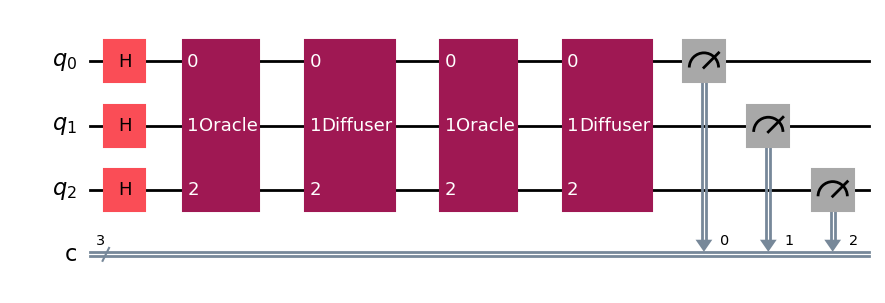

In [205]:
qc.draw('mpl')

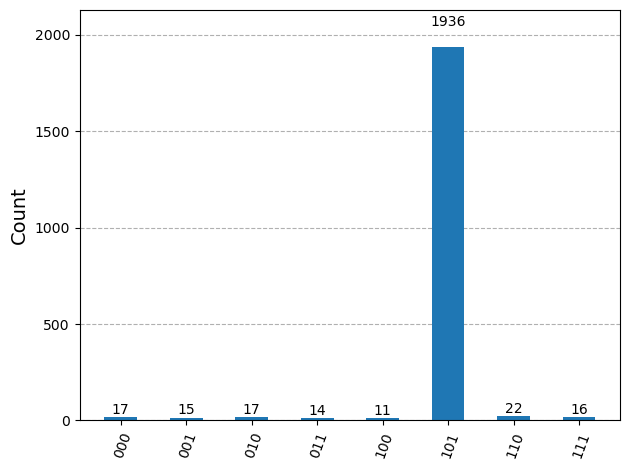

In [207]:
plot_histogram (counts)

**Task** : Plot the amplitude evolution of the target state across iterations

**Answer** : I have stored the probability of measuring 101 after each iteration and plotted it in the end. We cannot use qc.measure after each iteration and use the counts because after measurement, the superposition would collapse to one of the eight basis states.

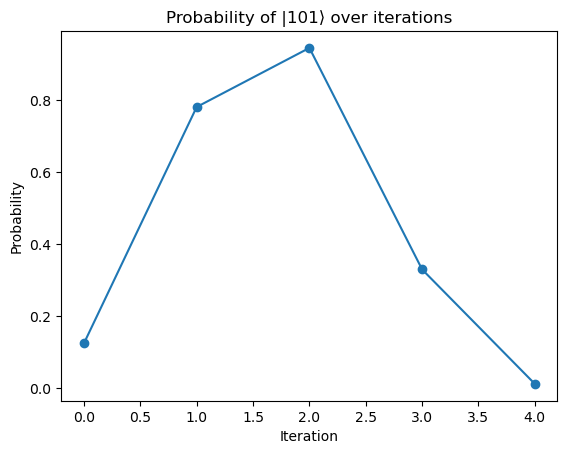

In [209]:
from qiskit.quantum_info import Statevector

probs = []  #list to store the probabilities
target_index = int('101', 2) #this converts the state vector 101 to binary, hence target index = 4*1 + 2*0 + 1*1 = 5

qc = QuantumCircuit(n)
qc.h(range(n))

sv = Statevector.from_instruction(qc)  #this gets the state vector representation from the current quantum circuit qc
probs.append(abs(sv.data[target_index])**2) #this takes the amplitude of 101 and squares its magnitude to get probability
# We cannot directly square without taking the abs value because amplitude can be imaginary

for _ in range(4):  # trying up to 4 iterations
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))
    sv = Statevector.from_instruction(qc)
    probs.append(abs(sv.data[target_index])**2)

plt.plot(probs, marker='o')
plt.title("Probability of |101⟩ over iterations")
plt.xlabel("Iteration")
plt.ylabel("Probability")
plt.show()

**Explanation** : The probability decreases from 3rd iteration because till then, the amplitude of the solution had been magnified good enough. Now when we applied the oracle, the amplitude flip caused the mean to become negative and hence, after the diffuser, magnitude of solution decreased. That's why calculating number of iterations beforehand is helpful.

**Question** : Why Grover’s algorithm works better than classical search

**Answer** : Classical search goes through each data piece to check whether that is our solution or not. Hence the average number of iterations we need for it is N/2. But Grover's algorithm exploits superposition; it magnifies the amplitude of the solution qubit(s) which gives us a higher probability of them being measured. With this, the number of iterations required decreases polynomially, since everytime the amplitude increases by more than $1/\sqrt N$ .

# Bonus Challenge

Can you generalize your circuit to work for any 3-bit target state, not just |101⟩? Can you scale it to 4 qubits and still correctly identify a marked state?

**Answer** : To do this, we just need to take input of the solution from the user and substitute that in place of the hard coded solution = '101'. After this we can parse the input and find out the number of qubits and therefore change n accordingly. Rest everything remains the same as everything else is dependent solely on n.

In [306]:
solution = input("Enter the marked state (bitstring, e.g., 101 or 1101): ").strip()
n = len(solution)

print(f"Running Grover's Algorithm on {n} qubits to find {solution}")

Enter the marked state (bitstring, e.g., 101 or 1101):  1101


Running Grover's Algorithm on 4 qubits to find 1101


**Note** : Lets try running this to see the output

In [320]:
qc = QuantumCircuit(n, n)
qc.h(range(n))

N = 2**n
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N)))
print(f'Number of Grover iterations: {iterations}')

oracle = grover_oracle(n, solution)
diffuser = grover_diffuser(n)

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

qc.measure(range(n), range(n))

from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(counts)

Number of Grover iterations: 3
{'0100': 5, '1101': 1973, '1110': 7, '0110': 7, '1011': 6, '1100': 7, '1000': 5, '1001': 4, '0101': 7, '0000': 4, '1111': 6, '0111': 5, '0011': 4, '1010': 3, '0001': 1, '0010': 4}


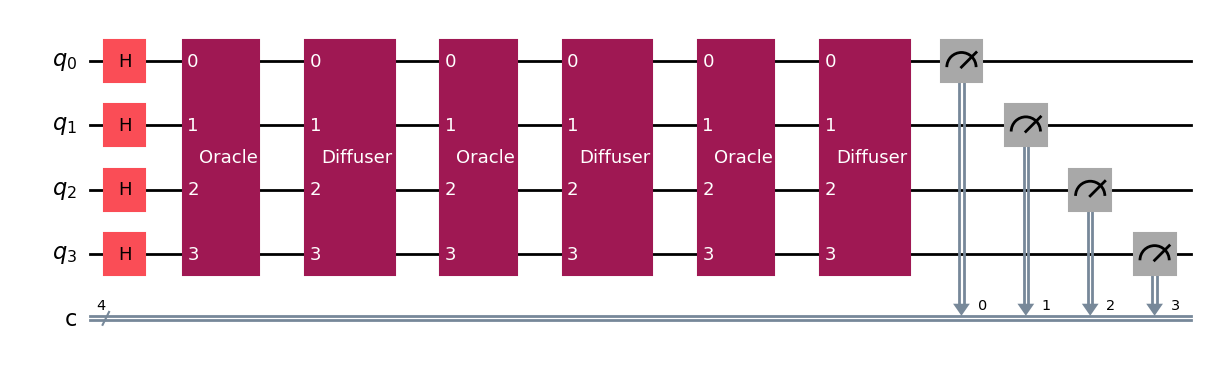

In [322]:
qc.draw('mpl')

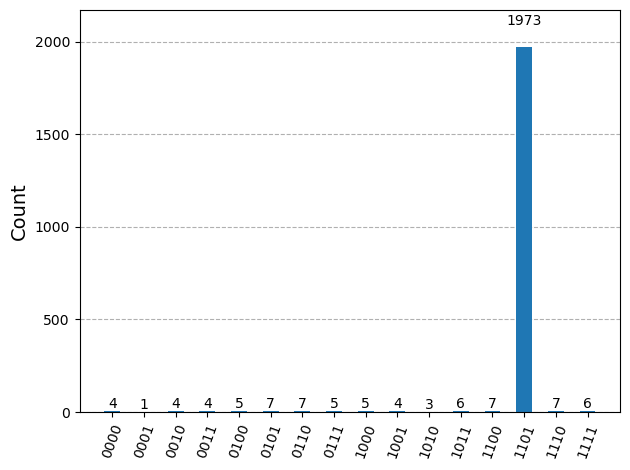

In [324]:
plot_histogram(counts)

**Damn!**

# Question 1 samaapt

# Question 2 aarambh

# Problem Setup

You are given a Boolean formula of the following form:

(x1∨¬x2∨x3)∧(¬x1∨x2∨x3) 

This formula has 3 variables:  x1,x2,x3 , leading to  23=8  possible input combinations. Your objective is to identify which of these combinations (if any) satisfy the given formula using Grover’s algorithm.

In [212]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit.library import PhaseOracle

In [214]:
n = 3     # n = 3 since we have x1, x2, x3  
N = 2**n  
M = 6     # no. of satisfying solutions

**Task** : Convert the 3-SAT Boolean formula into a classical Boolean function that returns 1 for satisfying inputs and 0 otherwise.

In [216]:
def SAT_fn (x1, x2, x3):
    clause1 = x1 or (not x2) or x3
    clause2 = (not x1) or x2 or x3
    return clause1 and clause2

**Task** : Encode this Boolean function into a quantum oracle. You may use Qiskit's PhaseOracle or implement your own custom logic.

In [218]:
expression = '(x3 | ~x2 | x1) & (x3 | x2 | ~x1)'
oracle = PhaseOracle (expression)

**Note** : I have switched x1 and x3 to reverse the order since Qiskit uses the reversed order of qubits than the conventional one

----

Diffuser Operator

In [220]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

**Task**

Determine the number of Grover iterations using the formula r = floor ((pi/4)*sqrt(N/M))

where  M  is the number of satisfying solutions. If unknown, use  M=1  as an approximation for small cases.

**Note** : Here I have taken M = 6. The only 2 combinations which don't satisfy the boolean expression are 100 and 010.

In [222]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N/M)))
print(f'Number of Grover iterations: {iterations}')

Number of Grover iterations: 0


**Explanation** : The reason for getting number of iterations 0 is that 6/8 solutions already satisty the boolean expression,
that is, any random measurement on the uniform 2**n superposition state would give us, with a 75% certainty, 
a qubit which satisfies the expression. So, the amplitude is already good enough, therefore no oracle and
diffuser operation required.

-------

**Task**

Initialize a uniform superposition over all  2**n  basis states using Hadamard gates.

Construct the full Grover circuit, including the oracle and the diffusion operator.

Add classical registers - the second n in QuantumCircuit (n,n)

In [224]:
qc = QuantumCircuit(n,n)
qc.h(range(n))

diffuser = grover_diffuser(n)

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

**Task** : Measure the quantum state after completing the Grover iterations

In [226]:
qc.measure(range(n), range(n))

**Task** : Simulate the circuit and identify the most probable outputs

In [228]:
from qiskit import transpile

backend = AerSimulator()
shots = 2048
transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, shots=shots).result()

**Task** : Draw the quantum circuit using Qiskit's visualization tools

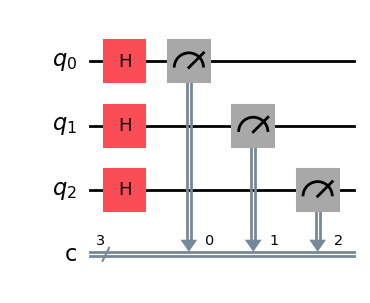

In [230]:
qc.draw('mpl')

**Explanation** : We got this circuit since, after applying the Hadamard gates, we got iterations = 0 as discussed above, and hence no
oracle or diffuser gates were applied. And we measured after that.

-------

**Task** : Plot the histogram of measurement outcomes

{'111': 265, '100': 255, '000': 267, '110': 237, '011': 279, '001': 223, '101': 279, '010': 243}


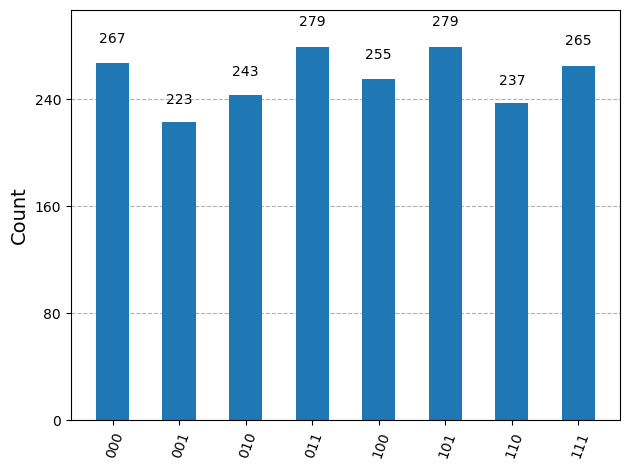

In [232]:
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

**Explanation** : We got this plot because after applying Hadamard gate, we get probability of all the qubits as root(1/8),
                  and we measured after this without applying anymore gates.

----

**Task** : Verify whether the measured bitstrings satisfy the original 3-SAT formula

**Explanation** : If we group all the qubits which satisfy the solution, we get the set (000, 001, 011, 101, 110, 111) and the ones not satisfying are (010, 100). So if we normalize the probabilities again for these 2 sets, we get the probability of getting solution set as approximately 3/4 that is 75% (as predicted earlier) and for the non solution set, approx. 1/4 that is 25%. So we have a good probability of getting a solution measured.

-------

# Bonus Challenge

Analyze the impact of incorrect estimates of  M  on the algorithm’s success rate.

**Answer** : Lets take M = 1 instead of 6

Number of Grover iterations: 2


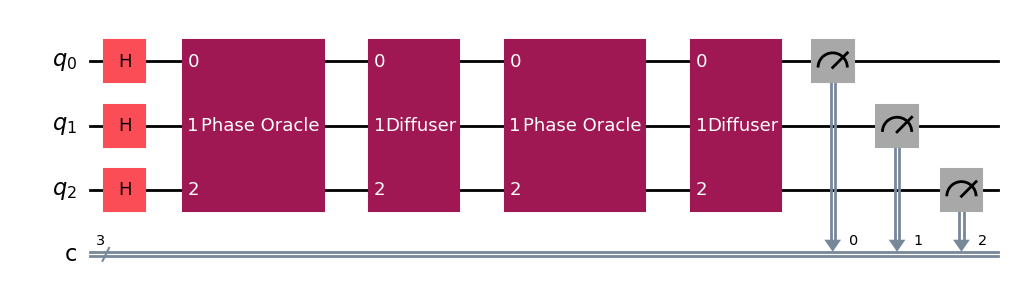

In [234]:
qc = QuantumCircuit(n,n)

# Step 1: Apply Hadamard to all qubits to create superposition
qc.h(range(n))

# Step 2: Apply Grover iterations
diffuser = grover_diffuser(n)

M = 1   #The crucial step

iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N/M)))
print(f'Number of Grover iterations: {iterations}')

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

qc.measure(range(n), range(n))

from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()

qc.draw('mpl')

**Explanation** : We have iterations = 2, therefore applied the Oracle Diffuser pair twice. Hence the circuit is as per our expectation.

{'110': 270, '101': 241, '001': 264, '011': 247, '111': 263, '000': 266, '100': 235, '010': 262}


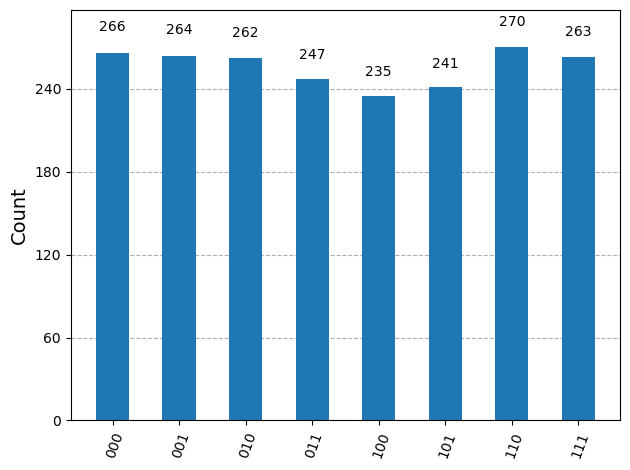

In [236]:
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

**Explanation** : We still got the same result as with M = 6, iterations = 0 

Now lets try with iterations = 1, and for that we can take M = 2, 3, 4. Lets take M = 3.

Number of Grover iterations: 1


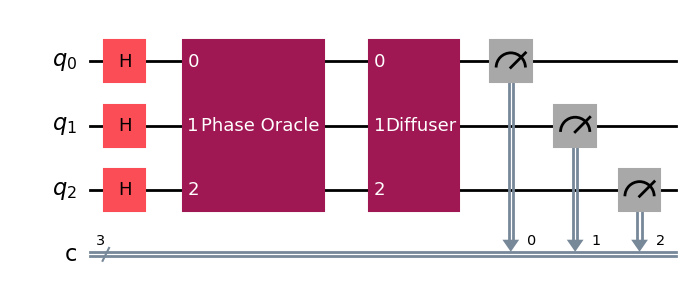

In [238]:
qc = QuantumCircuit(n,n)

# Step 1: Apply Hadamard to all qubits to create superposition
qc.h(range(n))

# Step 2: Apply Grover iterations
diffuser = grover_diffuser(n)

M = 3   #The gamechanging step

iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N/M)))
print(f'Number of Grover iterations: {iterations}')

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

qc.measure(range(n), range(n))

from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()

qc.draw('mpl')

{'010': 1052, '100': 996}


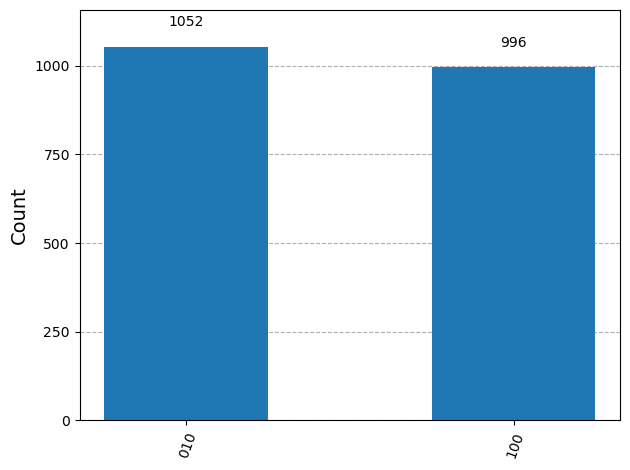

In [240]:
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

**Explanation** : At first glance, this result is surprising, but if we do the math, it becomes clear why we got this. 

Initially all the probabilities are $1 / \sqrt8$ . Now when we apply the oracle, the amplitudes of all the 6 solutions get flipped and we get the mean amplitude as

$(2/ \sqrt8 - 6/ \sqrt8) * 1/8 = -1/ 2 \sqrt8$

Now, when we apply the diffuser and flip all the amplitudes about the mean, using the formula alpha_dash = 2*mean - alpha, for the non solution set we get

$-1/ \sqrt8 - (1/ \sqrt8) = -2/ \sqrt8$

And for the solution set we get

$-1/ \sqrt8 - (-1/ \sqrt8) = 0$ ! (that's an exclamation mark not a factorial sign :) )

So we figure out that after one iteration, we get the amplitude of solution set to be 0 and for non solution set we get the total amplitude 1.

But wait, why did we get solutions for iterations = 2?
Let's do the Math here too 

On applying oracle again, we get individual amplitude of non solution set as $2/ \sqrt8$ which is equal to $1/ \sqrt2$. Now the mean is  

$2/ \sqrt2 * 1/8 = 1/ 4 \sqrt2$  

Applying diffuser again, we have amplitude of solution set as 

$1/ 2 \sqrt2 - 0 = 1/2 \sqrt 2 = 1/ \sqrt8$ ! (again that's an exclamation mark :D)

And for non solution set,

$1/ 2\sqrt2 - (1/ \sqrt2) = -1/\sqrt8$ 

Hence the result

----

Lets try with iterations = 3. I know its not possible for any value of M but I'm interested in finding out the result since after 2 iterations, we didn't get all probabilities as $1/\sqrt8$, we got 2 probabilities as negative of this

Number of Grover iterations: 3


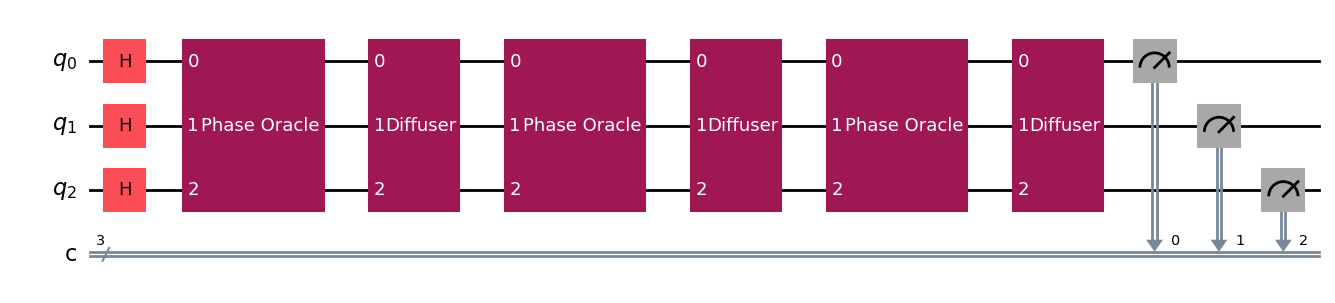

In [242]:
qc = QuantumCircuit(n,n)

# Step 1: Apply Hadamard to all qubits to create superposition
qc.h(range(n))

# Step 2: Apply Grover iterations
diffuser = grover_diffuser(n)

M = 3   #The gamechanging step

iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N/M))) 
print('Number of Grover iterations: 3')

iterations = 3  # HERE

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))

qc.measure(range(n), range(n))

from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()

qc.draw('mpl')

{'001': 262, '101': 233, '110': 285, '010': 271, '000': 254, '100': 234, '111': 236, '011': 273}


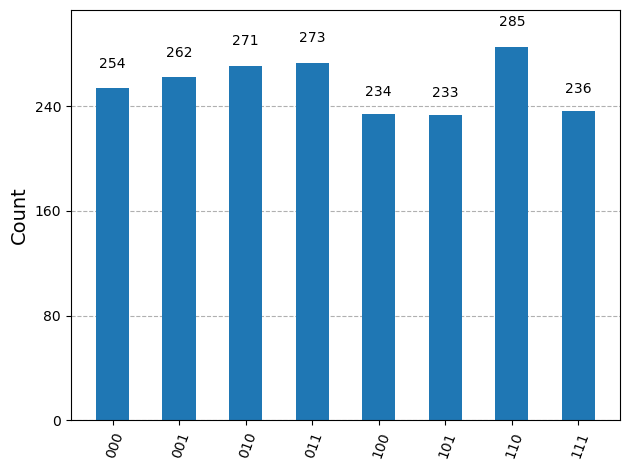

In [244]:
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

**Explanation** : This is as expected, since after thrid oracle we get all amplitudes as $-1/\sqrt8$, and then reflection about mean doesn't change the amplitudes since all amplitudes are equal. Therefore we again get the result that we got for iteration = 0 and 2

------

# Bonus Challenge

Extend your implementation to support arbitrary 3-SAT formulas with 3 or more variables.

**Answer** : Now, instead of hardcoding the expression into the Phase Oracle, and instead of assuming n = 3, we have to generalise it. We will first take input from the user for the boolean expression, in CNF form. Then we will parse the formula to figure out what n we should use. Rest of the code remains the same.

In [246]:
from sympy import symbols
from sympy.logic.boolalg import to_cnf
from qiskit.circuit.library import PhaseOracle

In [252]:
expression = input("Enter your 3-SAT formula in CNF in reversed order (e.g., if you want to input (x1 | ~x2 | x3) & (~x1 | x2 | x3), then type (x3 | ~x2 | x1) & (x3 | x2 | ~x1): ")
oracle = PhaseOracle(expression)

n = oracle.num_qubits  # number of variables

Enter your 3-SAT formula in CNF in reversed order (e.g., if you want to input (x1 | ~x2 | x3) & (~x1 | x2 | x3), then type (x3 | ~x2 | x1) & (x3 | x2 | ~x1):  (x4 | x3 | ~x2 | ~x1) & (x4 | ~x3 | x2 | x1)


In [254]:
print (n)

4


Now that we have n, we can use everything else the exact same way as used above since every function and variable's formula (like N = 2**n) depend solely on n

We only need to adjust the value of M which can either be assumed to be one or calculated manually

# THE END